In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
np.set_printoptions(legacy = '1.25')

import diem
import time

import sys
import os

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare Data for `diem` analysis

## Convert vcf file to diem input files

In [9]:
vcfFile = './data/iphiclides_example.vcf.gz'

In [10]:
os.system('vcf2diem '+vcfFile)

60,000 vcf sites for 20 genomes, split to 14,635 diem variants with 45,365 excluded. (76% reduction).
diem_meta.bed data saved to ./data/iphiclides_example.vcf.gz.diem_meta.bed
diem_input.bed data saved to ./data/iphiclides_example.vcf.gz.diem_input.bed
diem_exclude.bed data saved to ./data/iphiclides_example.vcf.gz.diem_exclude.bed
Time taken (hours:mins:secs): 0:00:01.780068


0

## Update Ploidy information

vcf2diem generates a meta data file that provides information on chromosome lengths as well as the ploidy of each chromosome for each individual. 

By default, it assigns a ploidy of 2 across all individuals and chromosomes.  However, for some chromosomes, this will not be the case.  For example, in an XY system, the male is haploid for the X chromosome.  

In our example, we provide a file to update and correct this information.

We apply this update using the update_ploidy function

In [11]:
metaRawFile = './data/iphiclides_example.vcf.gz.diem_meta.bed'

ploidyFile = './user_files/iphiclides_ploidy_update.txt'

metaCorrected = './data/iphiclides_example.vcf.gz.diem_meta_corrected.bed'

In [12]:
diem.update_ploidy(ploidyFile,metaFilePathIn=metaRawFile,metaFilePathOut=metaCorrected)

Updated ploidy for chromosome_Z

All chromosomes and individuals matched successfully.
Updated metadata saved to ./data/iphiclides_example.vcf.gz.diem_meta_corrected.bed


# Reading data into diemPy

We now have our inbut bed file and our *corrected* meta data file.  

We can read that in as a 'raw' or 'unpolarized' DiemType object.

The DiemType is a class which holds the data and provides the core functionality of diem. Refer to documentation for full details.

Here, we will simply show how it is used in a standard workflow. 

In [13]:
bedInFile = './data/iphiclides_example.vcf.gz.diem_input.bed'
metaCorrected = './data/iphiclides_example.vcf.gz.diem_meta_corrected.bed'


In [14]:
dRaw = diem.read_diem_bed(bedInFile,metaCorrected)


# Polarization

To polarize the data, we simply call the polarize() function of the DiemType object we created above.

Note:
- that it defaults to a parallel evaluation using the full number of available cores. We can change the number of cores manually using the 'ncores=' optional argument.  If n=1, it performs a serial polarization of the data.
- it returns a separate *copy* of the DiemType object that is now polarized. That is, the raw object is not changed.

In [15]:
dPol = dRaw.polarize(ncores=4)

convert state matrix to Marray
initializing random polarity
running EM algorithm in parallel using diem_parallel with  4  cores
starting
using  4  CPUs
iteration  0   num 0 polarity =  7166   num 1 polarity =  7469
time to flip:  0.18062543869018555
iteration  1   num 0 polarity =  12002   num 1 polarity =  2633
time to flip:  0.15922331809997559
iteration  2   num 0 polarity =  12898   num 1 polarity =  1737
time to flip:  0.10833382606506348
iteration  3   num 0 polarity =  12881   num 1 polarity =  1754
time to flip:  0.14818406105041504
iteration  4   num 0 polarity =  12881   num 1 polarity =  1754
time to flip:  0.1386420726776123
polarity found
polarity found
updating polarizations, DIs, Supports, initialPolarity,and state matrices


We can now save this to a bed file which has the same format as the input file but added information from polarization

In [16]:
bedOutFile = './output/diem_output.bed'
diem.write_polarized_bed(bedInFile,bedOutFile,dPol)


We can also save this directly as a diemtype object. 

It uses less memory, and it is how we will work with the data moving forward.

However, it is only useable within the diem environment. 

In [17]:
polarizedDiemTypeOutFile = './output/example_polarized.diemtype'

diem.save_DiemType(dPol,polarizedDiemTypeOutFile)


If we have already polarized the data, we can load the data back in either way:

In [18]:
dPol = diem.load_DiemType(polarizedDiemTypeOutFile) 
#or
dPol = diem.read_diem_bed(bedOutFile,metaCorrected)

# Hybrid Indices and Sorting 

the `diem` algorithm sorts individuals by hybrid index and seeks to maximize the differences between two sets of individuals on either side of a barrier to gene flow.

although the hybrid indices are calculated on polarization, the individuals are not sorted by hybrid index as we can see here:

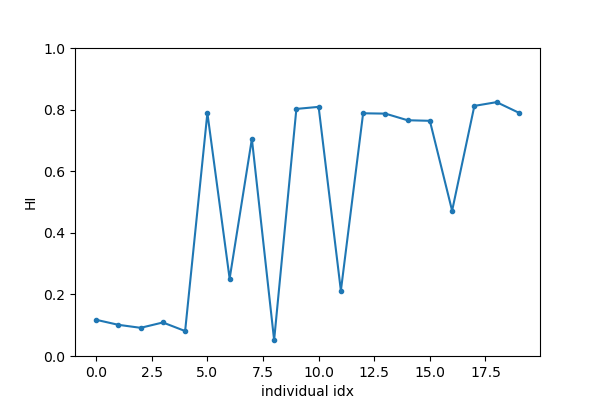

In [19]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(dPol.HIs,marker='.',)
plt.ylim(0,1)
ax.set_ylabel('HI')
ax.set_xlabel('individual idx')
plt.show()

We can use the sort() function to sort the individuals. 

In [20]:
dPol.sort()

new HIs computer and individuals resorted by HI


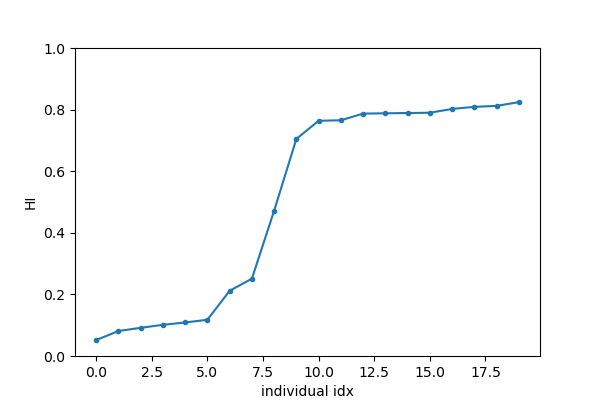

In [21]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(dPol.HIs,marker='.',)
plt.ylim(0,1)
ax.set_ylabel('HI')
ax.set_xlabel('individual idx')
plt.show()

# Plotting a Painting

Now that we have polarized and sorted the data, let's have a look at it using the plot_painting() function:

In [22]:
diem.plot_painting?

Signature: diem.plot_painting(diemMatrix, names=None, figSize=None, outputPath=None)
Docstring:
 Plot a painting of a diemMatrix. that is, an element of diemtype.DMBC, i.e., a diem matrix for a single chromosome.
 
Args:
    diemMatrix: A diem matrix for a single chromosome (element of diemtype.DMBC)
    names: Optional list of names for each individual (to label y-axis)
    figSize: Optional tuple specifying figure size (width, height)
    outputPath: Optional path to save the figure. Extension determines format (e.g., .png, .pdf)
    names: Optional list of names for each individual (to label y-axis)
 
File:      ~/git/diemPy/src/diem/utils.py
Type:      function

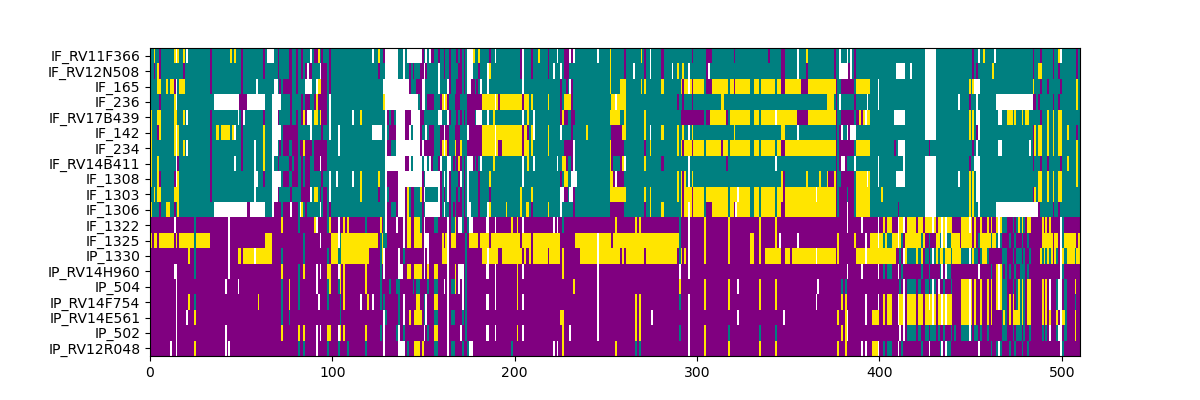

In [23]:
#here we are plotting chromosome 9
diem.plot_painting(dPol.DMBC[9],names=dPol.indNames)


Simply for illustration, let's compare this to the null polarization that diem started with:

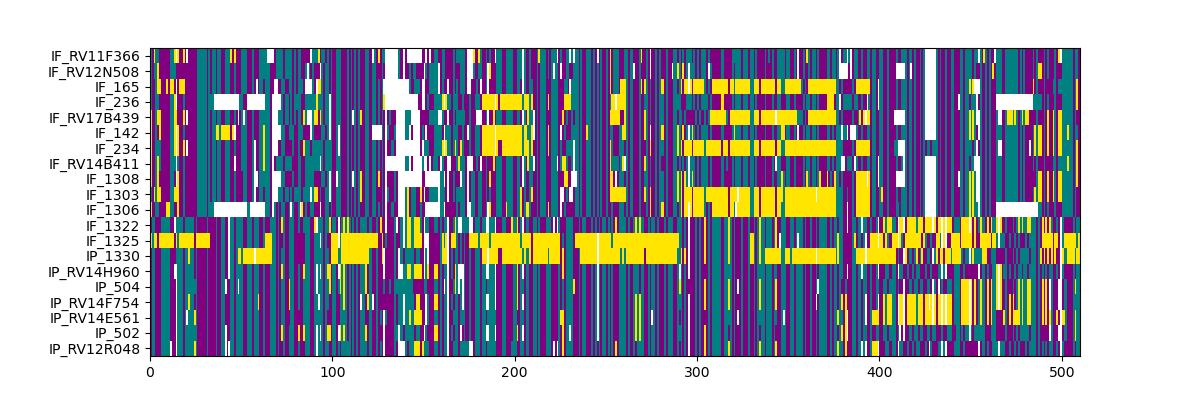

In [24]:
diem.plot_painting(diem.diemtype.flip_polarity(dPol.DMBC[9],dPol.initialPolByChr[9]),names=dPol.indNames)

# The Diagnostic Index (DI) and Thresholding

## The DI distribution 

Here we plot the distribution of diagnostic indices across the data.  For each of the final marker configurations, the diagnostic index tells use how well the marker matches does at explaining our data.  The least-negative value is the best.

In teal, we plot a histogram of the DI values for each unique marker.

In magenta, the counts of each marker are taken into account.

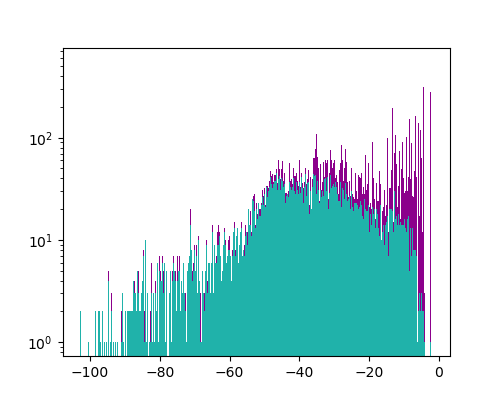

In [25]:
DIValsWithRepeats = np.hstack(dPol.DIByChr)
DIValsUnique = np.unique(DIValsWithRepeats)

fig,ax = plt.subplots(figsize=(5,4))
(counts,bins,patches) = ax.hist(DIValsWithRepeats,bins=500,color='darkmagenta')
ax.hist(DIValsUnique,bins=bins,color='lightseagreen')
plt.yscale('log')
plt.show()

We provide a function that will characterize the marker configurations, and provide information about each:  the count, the DI, the number of differences from the 'ideal marker' (the one with the highest DI) and how  many of the individuals have missing data for that marker. It returns a pandas dataframe.

This could be useful for exploring the data in greater detail when deciding on a threshold value in later steps.

**note** that this could be memory and time intensive to generate if there are many marker types.  We recommend characterizing only a subset of the most-informative markers to be on the safe side.  It is those markers that we will retain through thresholding later.



In [26]:
dfMarkers = diem.characterize_markers(dPol.apply_threshold(-50))
dfMarkers

proportion of each chromosome retained after thresholding:
[0.3187066974595843, 0.9385964912280702, 0.8884615384615384, 0.90020366598778, 0.9354838709677419, 0.9602272727272727, 0.8857142857142857, 0.9555189456342669, 0.9717314487632509, 0.8725490196078431, 0.9023255813953488, 0.9097222222222222, 0.9079754601226994, 0.9313543599257885, 0.9636048526863085, 0.9475890985324947, 0.9031007751937985, 0.9182561307901907, 0.7591973244147158, 0.8851174934725848, 0.905587668593449, 0.9056603773584906, 0.9444444444444444, 0.8984881209503239, 0.8691756272401434, 0.9395348837209302, 0.8555555555555555, 0.8733509234828496, 0.854, 0.9380234505862647]
thresholding done
hybrid indices have been updated
but individuals have NOT been resorted by HI.


configuration  count         DI  \
0     (1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, ...     11  -1.839685   
1     (1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, ...    282  -2.333242   
2     (1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, ...    541  -2.607709   
3     (1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, ...      2  -3.869406   
4     (1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 3, 3, 3, 3, ...    317  -3.999455   
...                                                 ...    ...        ...   
5492  (1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, ...      1 -49.986265   
5493  (1, 0, 1, 1, 1, 0, 2, 2, 0, 0, 3, 0, 0, 2, 0, ...      1 -49.986673   
5494  (1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, ...      1 -49.989179   
5495  (1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, ...      1 -49.991890   
5496  (1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...      1 -49.996122   

      diffs_from_ideal  individuals_missing  
0                    0                    0  
1                    1                    0  
2                    1                    0  
3                    1                    0  
4                    1                    0  
...                ...                  ...  
5492                 9                    0  
5493                12                    8  
5494                10                    6  
5495                13                    7  
5496                 9                    9  

[5497 rows x 5 columns]

## applying the final threshold chosen

The DI distribution for every dataset will be unique.  In the **Visualization** section of the tutorial, we provide further tools and guidance on choosing a threshold. 

For illustration here, we pick a threshold of -30.  

Thresholding returns a copy of the DiemType object, and it prints the proportion of markers retained for each chromsoome.

In [27]:
dThresh = dPol.apply_threshold(-30)

proportion of each chromosome retained after thresholding:
[0.11547344110854503, 0.5263157894736842, 0.6153846153846154, 0.6272912423625254, 0.5463709677419355, 0.6060606060606061, 0.4103896103896104, 0.7116968698517299, 0.7279151943462897, 0.5431372549019607, 0.6395348837209303, 0.5138888888888888, 0.5521472392638037, 0.7328385899814471, 0.708838821490468, 0.6582809224318659, 0.49806201550387597, 0.5204359673024523, 0.4230769230769231, 0.31592689295039167, 0.5568400770712909, 0.294811320754717, 0.5178571428571429, 0.5032397408207343, 0.6917562724014337, 0.6837209302325581, 0.4638888888888889, 0.48548812664907653, 0.554, 0.6063651591289783]
thresholding done
hybrid indices have been updated
but individuals have NOT been resorted by HI.


After thresholding, there will be fewer markers present, and those that remain have configurations which better support the genetic barrier. In effect, the data looks cleaner. We can see this by plotting chromosome paintings with markers in their physical positions, below, both before and after thresholding. 

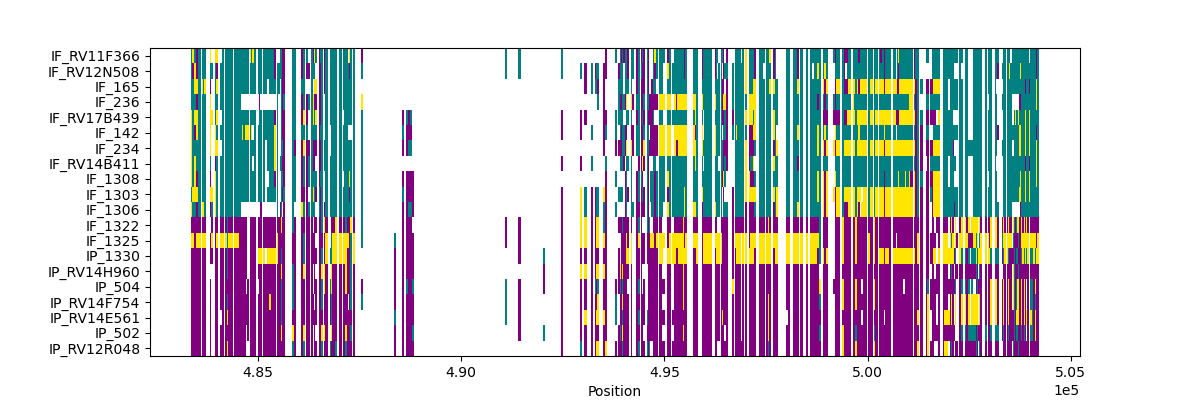

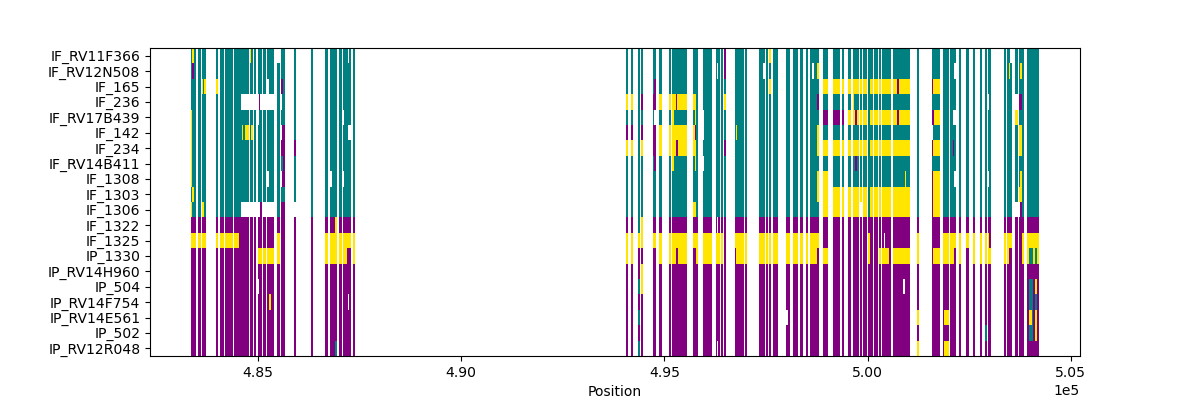

In [28]:
diem.plot_painting_with_positions(dPol.DMBC[9],dPol.posByChr[9],names=dPol.indNames)
diem.plot_painting_with_positions(dThresh.DMBC[9],dThresh.posByChr[9],names=dPol.indNames)

Below, we compare the hybrid indices before (blue) and after (red) thresholding: 

We can see that the separation of individuals is clearer now, and their hybrid indices have also changed.

We will not do this for now, but we could resort the individuals by HI by calling *dThresh.sort()*

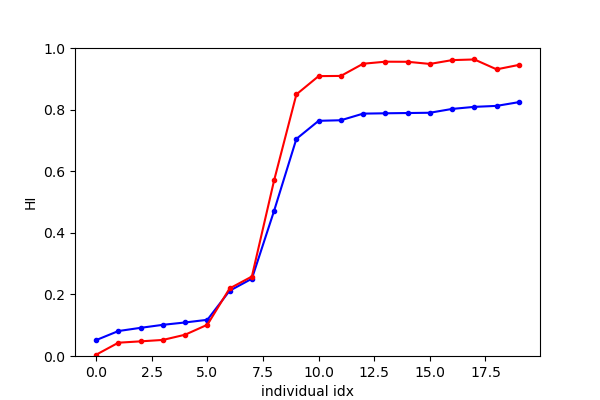

In [29]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(dPol.HIs,marker='.',color='b')
ax.plot(dThresh.HIs,marker='.',color='r')
ax.set_ylim(0,1)
ax.set_ylabel('HI')
ax.set_xlabel('individual idx')
plt.show()

# Smoothing the Data

After thresholding, we will see much clearer tracts representing shared ancestry with respect to the barrier.  However, there will be some bits of missing data, mis-called sites, etc. that will break up the tracts. We want to smooth this over for later analyses. We also care about tracts generated by cross-over recombination, but gene conversion events could also cause short changes in state and break up our tracts.  Therefore, we want to smooth over this noise and this signal in the data.

In the manuscript **(insert link when available)**, we explain the Laplacian smoothing kernel and how this smoothing is done on a recombination-based (map) distance rather than physical base pair position.

The default behaviour of DiemPy is to normalize the physical distances by chromosome length and use a global smoothing scale parameter across all chromosomes. This assumption can be relaxed, and we discuss this later in the **Advanced Smoothing** section.


Here, we use the default global scale, and to pick a smoothing scale, we examine how the data changes for different values.  Below, we calculate the number of sites that change across the whole dataset using the laplacian smoothign kernel:

In [30]:
scalesToTry = [1e-8,5e-8,1e-7,5e-7,1e-6,5e-6,1e-5,5e-5,1e-4,5e-4]
sitesDiffByScale = []
for scale in scalesToTry:
    dSmoothedTest = dThresh.smooth(scale)
    kdiffs = diem.count_site_differences(dSmoothedTest.DMBC,dThresh.DMBC)
    sitesDiffByScale.append(kdiffs)

smoothing the data with scale  1e-08
using parallel smoothing
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort
smoothing the data with scale  5e-08
using parallel smoothing
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort
smoothing the data with scale  1e-07
using parallel smoothing
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort
smoothing the data with scale  5e-07
using parallel smoothing
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort
smoothing the data with scale  1e-06
using parallel smoothing
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort
smoothing the data with scale  5e-06
using parallel smoothing
smoothing done, but not resorting by HI. You may

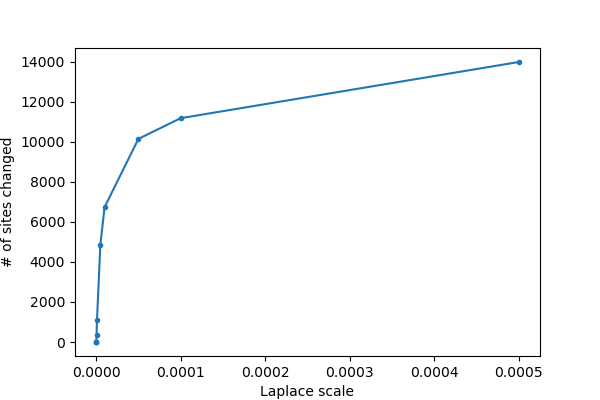

In [31]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(scalesToTry,sitesDiffByScale,marker='.')
ax.set_ylabel('# of sites changed')
ax.set_xlabel('Laplace scale')
plt.show()

We see that by around scale = 5e-5, the single-site changes and short tracts have been smoothed over, and we choose this as our final smoothing scale.

**note** smoothing returns a copy of the dataset with the same order (i.e. HIs are not recomputed and data is not resorted). That way, comparisons can be made easily before and after smoothing. 


In [32]:
dSmoothed = dThresh.smooth(5e-5)

smoothing the data with scale  5e-05
using parallel smoothing
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort


We can compare before and after smoothing to see how it has affected our data:

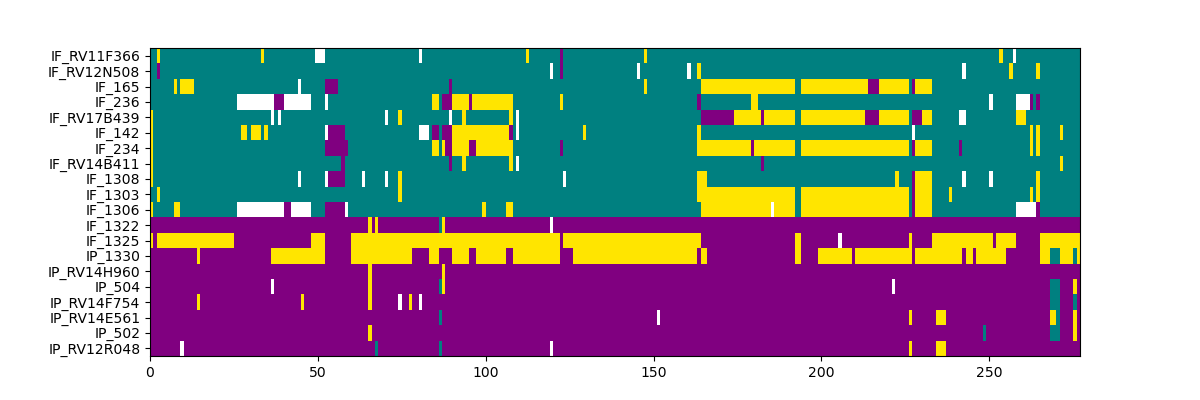

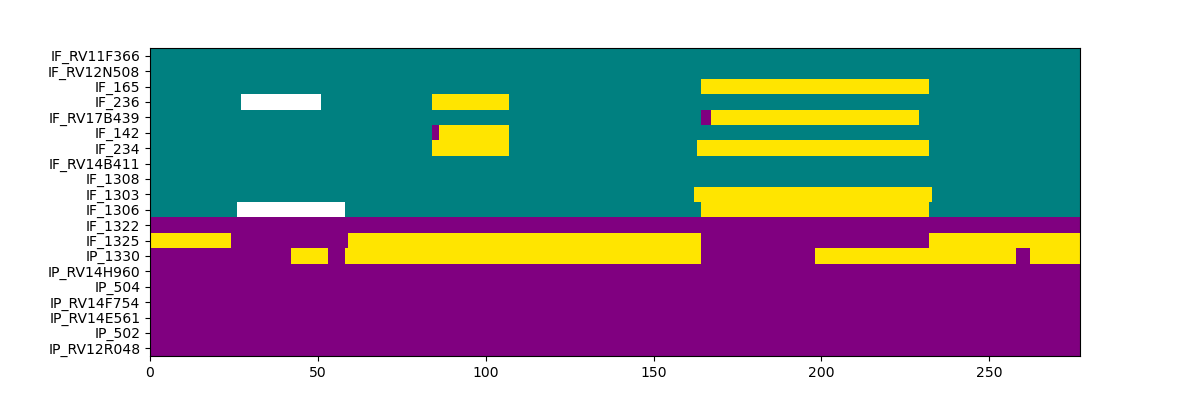

In [33]:
diem.plot_painting(dThresh.DMBC[9],dThresh.indNames)
diem.plot_painting(dSmoothed.DMBC[9],dSmoothed.indNames)

We can also see how smoothing has affected our HIs

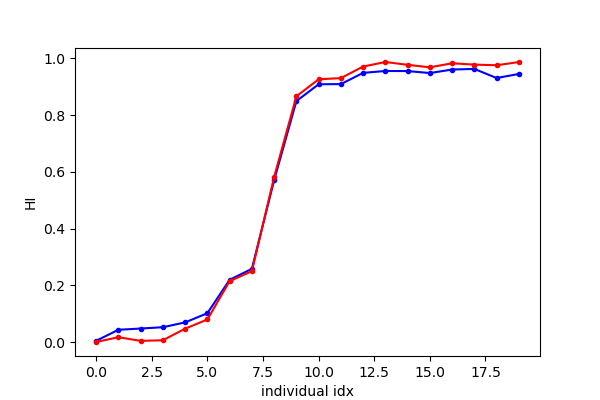

In [34]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(dThresh.HIs,marker='.',color='b')
ax.plot(dSmoothed.computeHIs(),marker='.',color='r')
ax.set_ylabel('HI')
ax.set_xlabel('individual idx')
plt.show()

After smoothing, we can see that the hybrid indices have changed, and we now do a final sort of the data:

new HIs computer and individuals resorted by HI


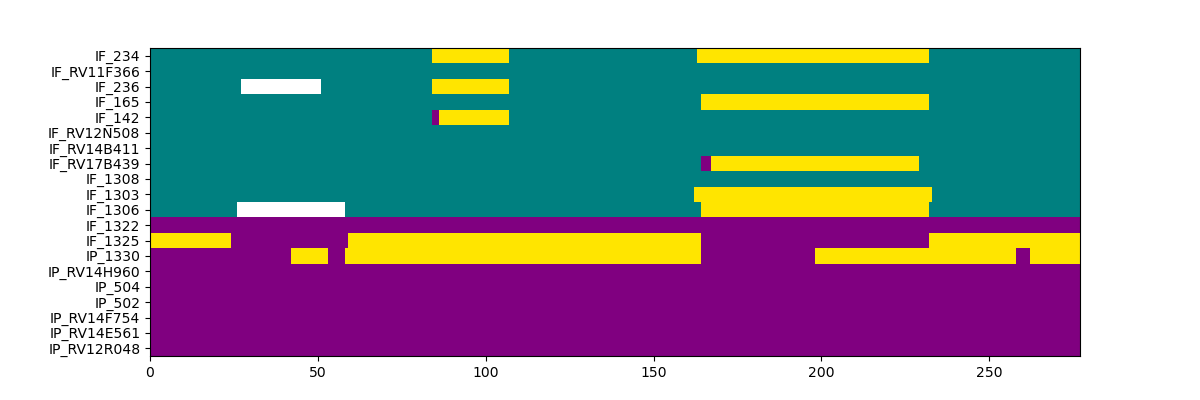

In [35]:
dSmoothed.sort()
diem.plot_painting(dSmoothed.DMBC[9],dSmoothed.indNames)

# Constructing Contigs

Downstream analyses of diem output may focus on the lengths of tracts of shared ancestry across the gene flow barrier.

Here, we provide the function create_contig_matrix() that generates 'contigs' for each chromosome of each individual.

a 'contig' is a summary of the data.  It is the sequence of contiguous intervals that form a givien chromosome 

Once we have created the contigs, we can export per-individual contig files in bed formatting 

In [36]:
dSmoothed.sort() # ensure that dSmoothed is sorted.
dSmoothed.create_contig_matrix()


HIs already up to date, and no sorting needed
contig matrix created and stored in self.contigMatrix


In [37]:
contingOutputDirectory = './output/contigs/'

diem.export_contigs_to_ind_bed_files(dSmoothed,contingOutputDirectory)


# Using Contigs & intervals

Within the diemtype objects, contigs are stored in the *contigMatrix*

the *contigMatrix* is an array wit shape nChrs x nIndividuals. and we can use splicing to access specific contigs. 

For chromosome indexed 1 and individual indexed 8:

In [38]:
exampleContig = dSmoothed.contigMatrix[1,8]
exampleContig.__dict__

{'intervals': [<diem.contigs.Interval at 0x7edc3c4256d0>,
 'num_intervals': 2,
 'indName': 'IF_1322',
 'chrName': 'chromosome_11'}

A contig stores the individual and chromosome names to which it belongs as well as a list of intervals and the number of intervals

In [39]:
?exampleContig

Type:        Contig
String form: <diem.contigs.Contig object at 0x7edc3fccb150>
File:        ~/git/diemPy/src/diem/contigs.py
Docstring:  
Represents a contiguous sequence of genomic intervals for a specific individual and chromosome.

Args:
    chrName (str): Chromosome name.
    indName (str): Individual name.
    intervalList (list): List of Interval objects.

:ivar str chr: Chromosome name.
:ivar str ind: Individual name.
:ivar int num_intervals: Number of intervals.
:ivar list intervals: List of Interval objects.

In [40]:
exampleContig.num_intervals

2

an **interval** is a contiguous segment of genome with the same ancestry.

It stores the chromosome and individual to which it belongs. the indices and positions of the left- and right-most markers,
and the state of the individual: 0, 1, 2, or 3.

In [41]:
exampleInterval = exampleContig.intervals[0]
?exampleInterval

Type:        Interval
String form: <diem.contigs.Interval object at 0x7edc3c4256d0>
File:        ~/git/diemPy/src/diem/contigs.py
Docstring:  
Represents a genomic interval for a specific individual and chromosome.

Args:

    chrName (str): Chromosome name.
    indName (str): Individual name.
    idxl (int): Left index (inclusive).
    idxr (int): Right index (inclusive). So slice of state matrix would be [idxl:idxr+1]
    l (float): Left position (physical).
    r (float): Right position (physical).
    state (int): State of the interval.

:ivar str chrName: Chromosome name.
:ivar str indName: Individual name.
:ivar int idxl: Left index (inclusive).
:ivar int idxr: Right index (inclusive). So slice of state matrix would be [idxl:idxr+1]
:ivar float l: Left position (physical).
:ivar float r: Right position (physical).
:ivar int state: State of the interval.

In [42]:
exampleInterval.__dict__

{'chrName': 'chromosome_11',
 'indName': 'IF_1322',
 'idxl': 0,
 'idxr': 28,
 'l': 495252,
 'r': 497849,
 'state': 2}

We can get the interval's span easily:

In [43]:
exampleInterval.span()

2597

And we can get the intervals map span (on a unit scale) if we provide the length of the chromsome.

In [44]:
exampleInterval.mapSpan(dSmoothed.chrLengths[1])

0.000151308265917548

Here is the information about all the intervals that form the genotype of our example contig:

In [45]:
[x.__dict__ for x in exampleContig.intervals]

[{'chrName': 'chromosome_11',
  'indName': 'IF_1322',
  'idxl': 0,
  'idxr': 28,
  'l': 495252,
  'r': 497849,
  'state': 2},
 {'chrName': 'chromosome_11',
  'indName': 'IF_1322',
  'idxl': 29,
  'idxr': 179,
  'l': 498123,
  'r': 512689,
  'state': 3}]

We can plot the tract length distribution for all intervals with state '1'

# Plotting tract length distributions

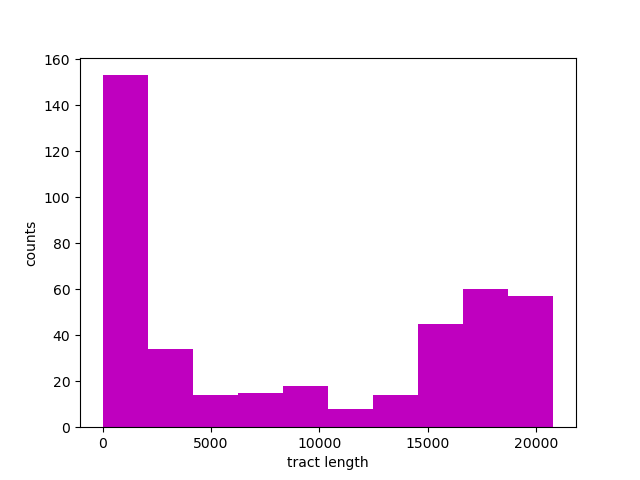

In [46]:
oneTracts = dSmoothed.get_intervals_of_state(1)
oneLengths = [x.span() for x in oneTracts]
fig,ax = plt.subplots()
ax.hist(oneLengths,color='m')
ax.set_ylabel('counts')
ax.set_xlabel('tract length')
plt.show()

We can plot the distribution of the different types of tracts together

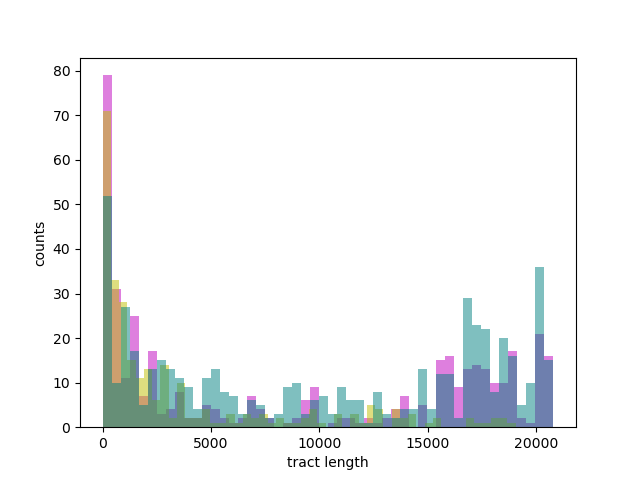

In [47]:
fig,ax = plt.subplots()
ax.hist([x.span() for x in dSmoothed.get_intervals_of_state(1)],bins = 50,color='m',alpha = 0.5)
ax.hist([x.span() for x in dSmoothed.get_intervals_of_state(2)],bins=50,color='y', alpha = 0.5)
ax.hist([x.span() for x in dSmoothed.get_intervals_of_state(3)],bins=50,color='teal', alpha = 0.5)
ax.set_ylabel('counts')
ax.set_xlabel('tract length')
plt.show()

# Advanced tract length distribution plotting

We can also subset individuals and chromosomes when getting intervavls of those types.

Suppose we want to compare the distribution of tract lengths on opposite sides of the barrier. By looking at the HIs of the smoothed data, we see there is one highly admixed individual, IF_1322, so we decide to exclude it here. 

We then identify the individuals clearly to the 'left (bottom)' and 'right (top)' sides of the barrier. 

In [48]:
[[i,dSmoothed.indNames[i],dSmoothed.HIs[i]] for i in range(len(dSmoothed.indNames))]

[[0, 'IP_RV12R048', 6.136475208640157e-05],
 [1, 'IP_RV14E561', 0.004057543341940244],
 [2, 'IP_RV14F754', 0.0061986007119184975],
 [3, 'IP_502', 0.016978346456692914],
 [4, 'IP_504', 0.047058823529411764],
 [5, 'IP_RV14H960', 0.07945593303791236],
 [6, 'IP_1330', 0.2146009562339095],
 [7, 'IF_1325', 0.24978064677864126],
 [8, 'IF_1322', 0.5817452357071213],
 [9, 'IF_1306', 0.8662283474522696],
 [10, 'IF_1303', 0.9262120070334087],
 [11, 'IF_1308', 0.9304294478527607],
 [12, 'IF_RV17B439', 0.9685059208868733],
 [13, 'IF_RV14B411', 0.9712261785356068],
 [14, 'IF_RV12N508', 0.9757689893283114],
 [15, 'IF_142', 0.9772299585999247],
 [16, 'IF_165', 0.9779862644101055],
 [17, 'IF_236', 0.9826987434488855],
 [18, 'IF_RV11F366', 0.9870056497175141],
 [19, 'IF_234', 0.9872278847363785]]

In [49]:
leftIndividualIndices = np.arange(8)
rightIndividualIndices = np.arange(9,20)
print(leftIndividualIndices)
print(rightIndividualIndices)

[0 1 2 3 4 5 6 7]
[ 9 10 11 12 13 14 15 16 17 18 19]


We can plot the spans of tracts of type '1' for individuals on the 'left' (blue) and 'right' (red) sides of the barrier, respectively. 

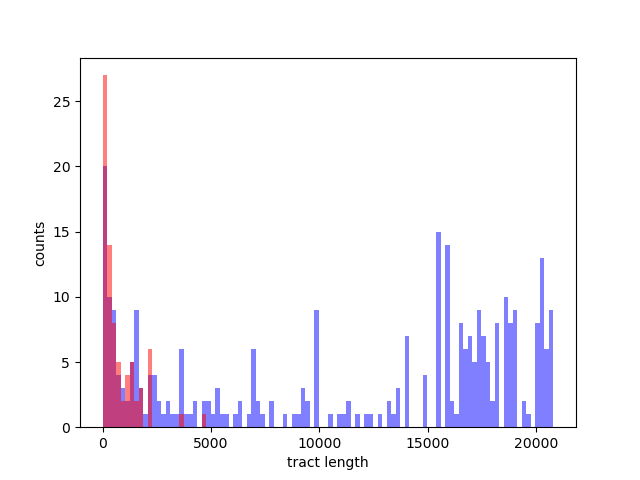

In [50]:
state1SpansLeftSide = [x.span() for x in dSmoothed.get_intervals_of_state(1,individualSubset=leftIndividualIndices)]
state1SpansRightSide = [x.span() for x in dSmoothed.get_intervals_of_state(1,individualSubset=rightIndividualIndices)]

fig,ax = plt.subplots()
longestSpan = max(max(state1SpansLeftSide),max(state1SpansRightSide))
ax.hist(state1SpansLeftSide,bins = 100,range=(0,longestSpan),color = 'b',alpha = 0.5)
ax.hist(state1SpansRightSide, bins = 100,range=(0,longestSpan), color = 'r',alpha = 0.5)
ax.set_ylabel('counts')
ax.set_xlabel('tract length')
plt.show()

Similarly, we can plot the spans of type '3' comparing the left and right sides of the barrier

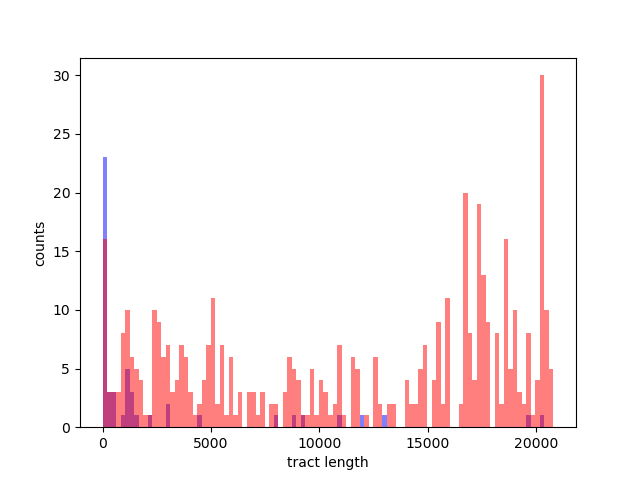

In [52]:
state3SpansLeftSide = [x.span() for x in dSmoothed.get_intervals_of_state(3,individualSubset=leftIndividualIndices)]
state3SpansRightSide = [x.span() for x in dSmoothed.get_intervals_of_state(3,individualSubset=rightIndividualIndices)]

fig,ax = plt.subplots()
longestSpan = max(max(state3SpansLeftSide),max(state3SpansRightSide))
ax.hist(state3SpansLeftSide,bins = 100,range=(0,longestSpan),color = 'b',alpha = 0.5)
ax.hist(state3SpansRightSide, bins = 100,range=(0,longestSpan), color = 'r',alpha = 0.5)
ax.set_xlabel('tract length')
ax.set_ylabel('counts')
plt.show()

# Visualisation

Polarisation has not changed your data, only coloured it and measured it. The **GenomeSummaryPlot** shows these colours, and the effects of ignoring sites with low diagnostic index (DI).

Sort individuals by their hybrid index using the red button. Slide the DI slider to the right to focus on barrier relevant sites. If your data is large, you may need to _click_ at your desired DI value rather than sliding. Mouse-over a plot symbol to see which individual it refers to. You can save the plot using the click-on tool or keyboard shortcut S.

**TOUCHDOWN DI**: As you slide DI to the right, first Unpolarisable (U, grey line) data will be filtered out (blanks and genotypes involving third states). Next the span of the hybrid indices (red line) should start to increase (you may wish to hit the red button to re-sort by the new HI). One way of choosing a DI threshold is to move right until 'touchdown' where the hybrid index goes to zero on one side of the barrier, and 1 on the other. An outlier individual may touchdown first, way before others; in that case keep going until other have joined. There is a trade-off: the further to the right, the cleaner the retained data with respect to the barrier, but the fewer sites in the genome are being considered.

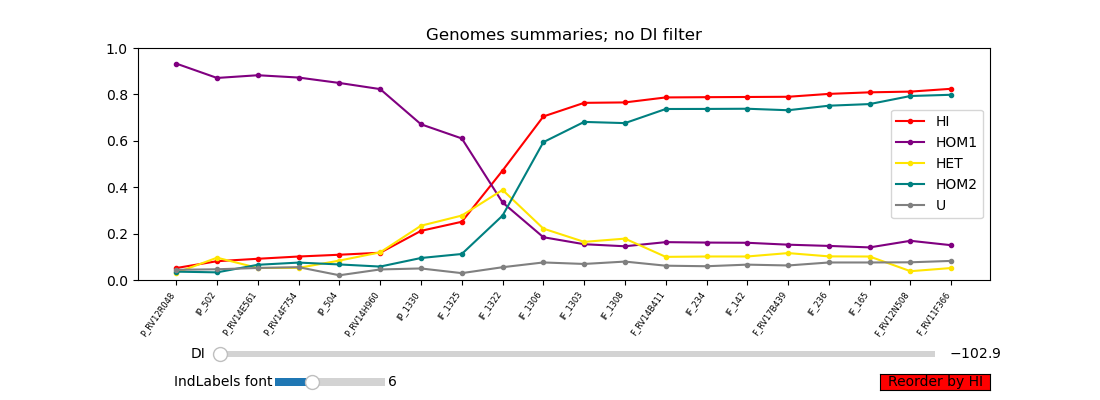

In [53]:
diem.plots.GenomeSummaryPlot(dPol)

The effects of DI sliding may not be equal across chromosomes - sex chromosome are often more relevant to barriers. **GenomeMultiSummaryPlot** allows you to explore this by specifying a list of chromosome to summarise as though each is a genome, while still showing the global HI plot (cyan) over all chromosome as reference.

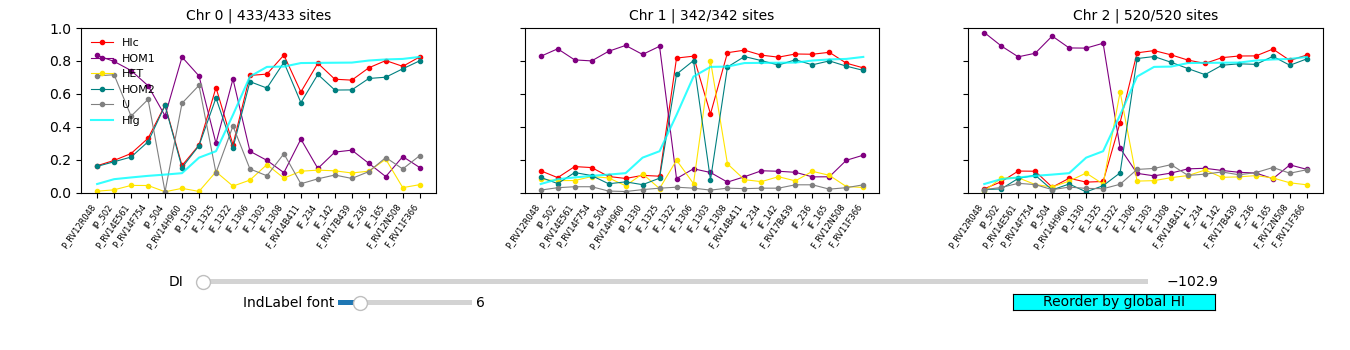

In [54]:
diem.plots.GenomeMultiSummaryPlot(dPol,[0,1,2])

There are many ways to summarise genomes with respect to the sites diagnosing a barrier. The **GenomicDeFinetti** diagram uses HOM1 HET HOM2 frequencies to place genomes in a ternary plot. The colours are a blend of not just these proportions, but also the Unpolarisable proportion (as White). Skim-sequenced genomes will, for example, have lighter shades due to more missing data.

The background parabola is analogous to Hardy-Weinberg equilibrium for HOM1 HET HOM2 frequencies at a single site of a genome. In current context the parabola is the genomic expectation if admixture is proceeding with local HWE in a simlar fashion throughout the genome (ie with similar admixture proportions).

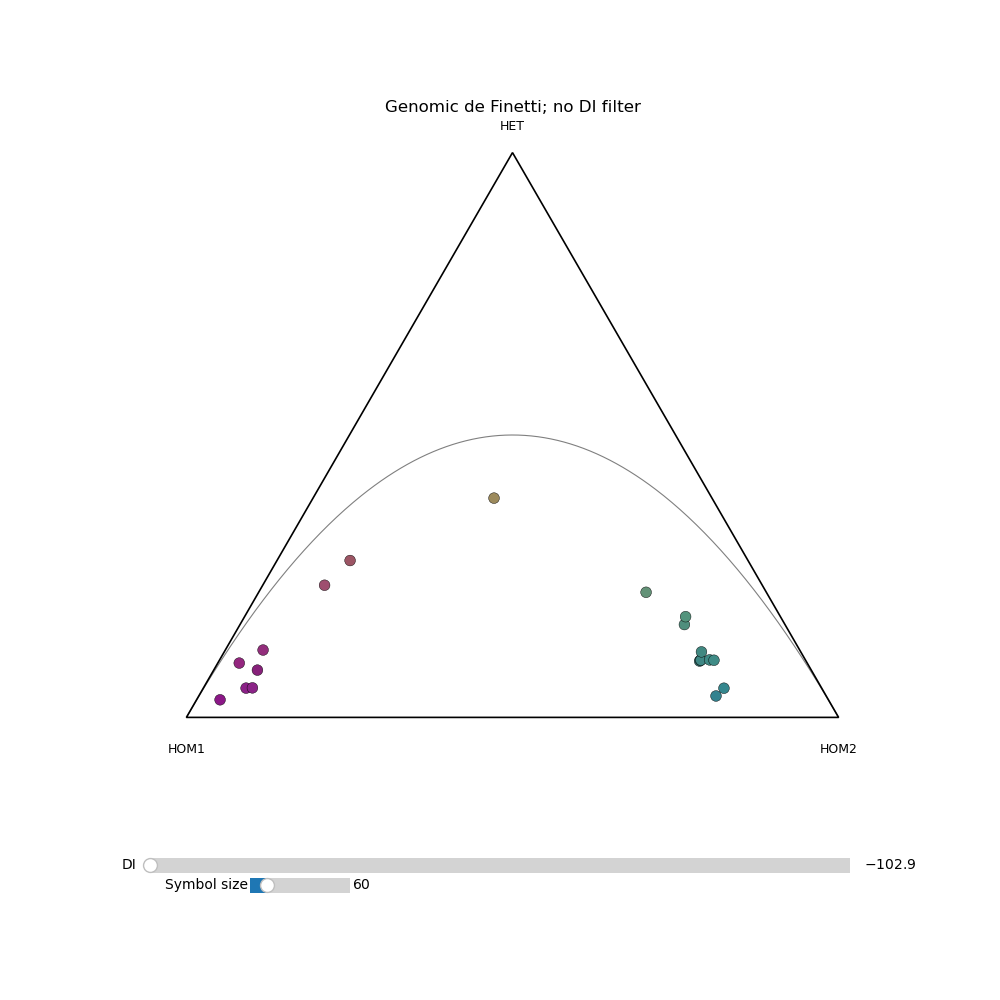

In [55]:
diem.plots.GenomicDeFinettiPlot(dPol)

Again, the effects of DI sliding may not be equal across chromosomes or genome regions. **GenomicMultiDeFinettiPlot** allows you to explore this at the level of chromosomes from the ternary perspective by specifying a list of chromosome to summarise as though each is a genome.

/home/derek/git/diemPy/src/diem/plots.py:1541: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.axes = plt.subplots(


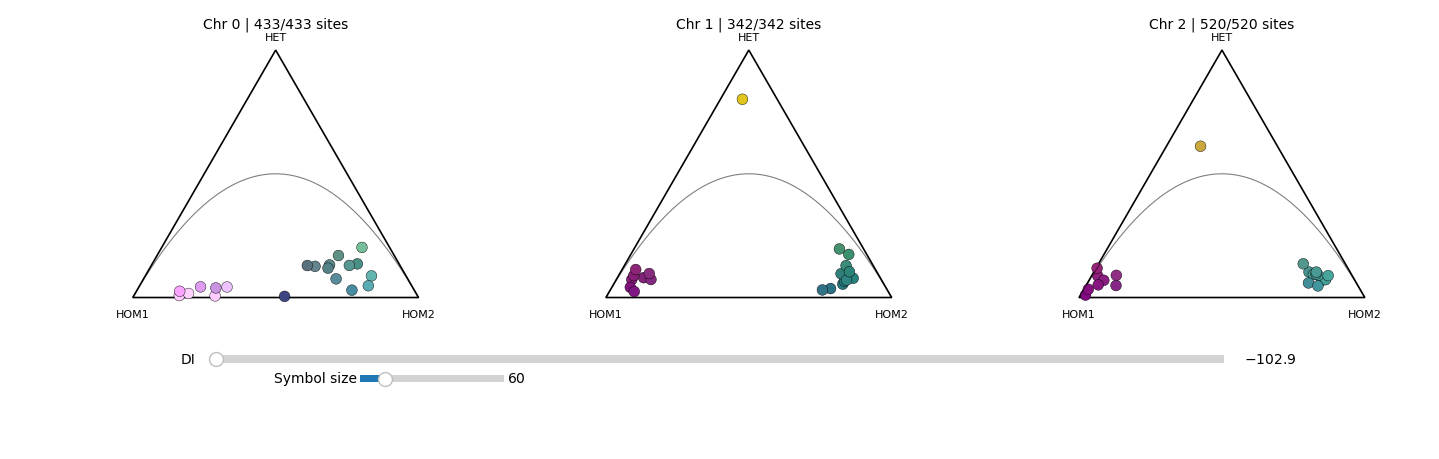

In [56]:
diem.plots.GenomicMultiDeFinettiPlot(dPol,range(3))

Another way of exploring the heterogeneity of barrier effects across the genome is to simply look at howmany sites are retained on each chromosome after DI sliding. **GenomicContributionsPlot** shows these contributions, and breaks them down by state: often sex chromsomes will contribute a lot, but with a lower HET proportion.

The resemblance to a graphical equaliser from an old stereo raises an analogy: sliding DI to the right, we see the channels (chromosomes) on which barrier signal is strongest.

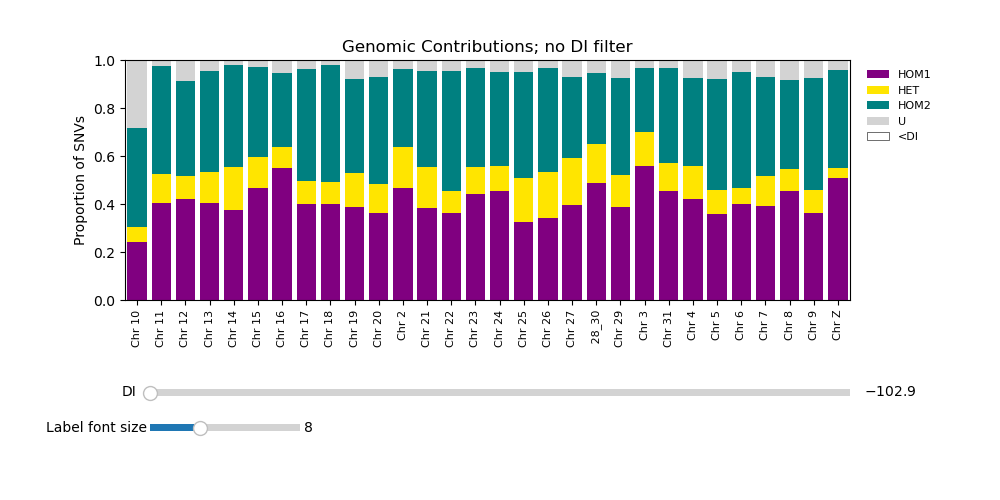

In [57]:
diem.plots.GenomicContributionsPlot(dPol)

It may be that admixture has produced an explosion of genome-types, such that genomes are all unique and their summaries change smoothly across the barrier. Alternatively, for eg a taxon of hybrid origin, a single along-genome blockwise admixture pattern may occur in multiple individuals. **diemPairsPlot** allows you to explore these possibilities through all pairwise comparison of the painted colours of the polarised genomes. 

The is a genomic O(n<sup>2</sup>) calculation... so choose one DI threshold at a time (maybe a touchdown DI) it may take a while before it plots.... be patient.

In the plot genomes are ordered simply by their hybrid index.

Blue squares indicate clusters of genomes which share detailed purple/teal long-genome pattern.

You may note the diagonal of self-to-self comparison is not always zero. The same distance function is applied for all comparisons (even self-to-self) in order to make it clear that, because _diem_ is ignorant of phase, comparison of HET genome tracts to HET genome tracts do **not** give distance zero. HOM1 vs HOM2 is distance 2. HET vs HET is (either 0 or 2 with phase unknown) => distance 1. (See Petruezela et al Mol Ecol 2025).

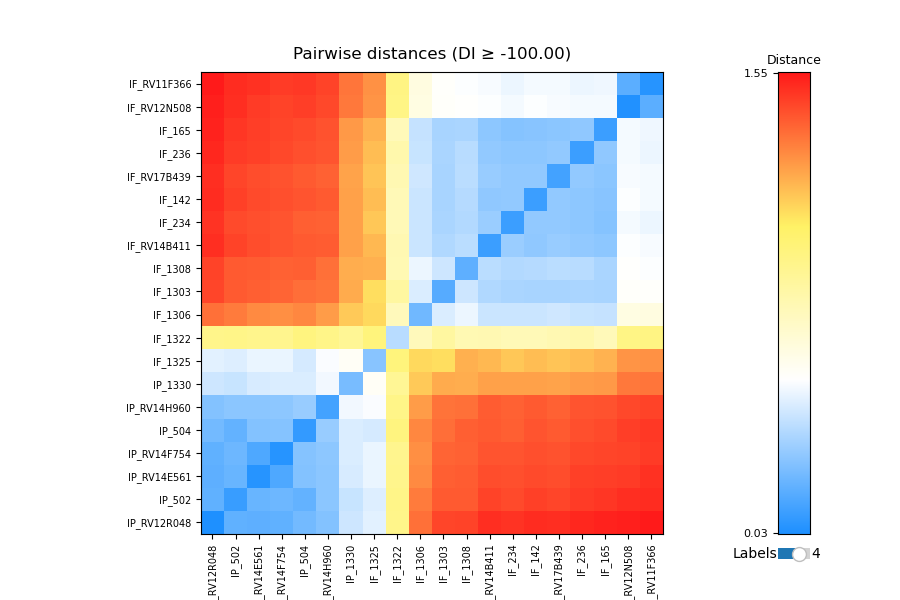

In [58]:
diem.plots.diemPairsPlot(dPol,-100)

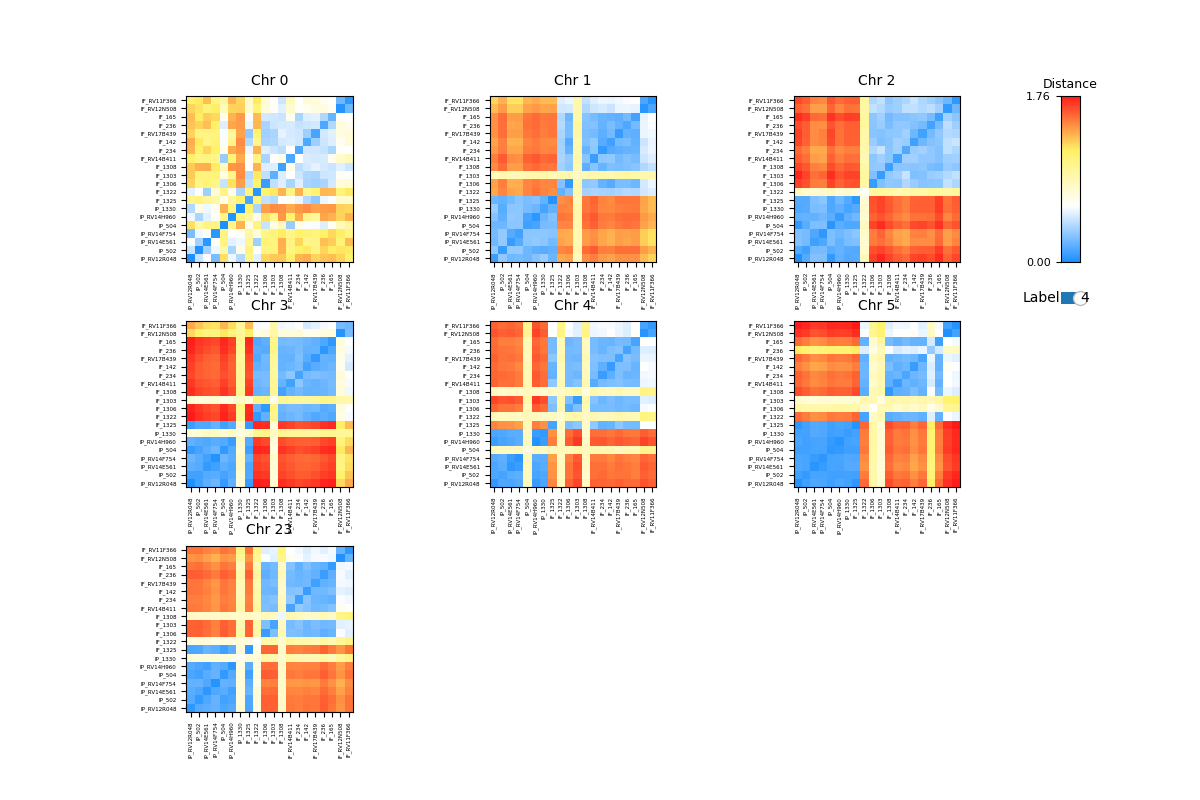

In [59]:
diem.plots.diemMultiPairsPlot(dPol,[0,1,2,3,4,5,23],-100)

We mentioned 'detailed purple/teal long-genome pattern'. What does this look like? **diemIrisFromPlotPrep** allows us to see this detail for the whole genome, for all the genomes, all at once. 

Again this is a computationally intensive task, so first we run a prepatory step **diemPlotPrepFromBedMeta**, which loads the data you saved in the **Polarisation** section and prepares is for the big plot of everything...

Give your plot a (short) theme.
Set the correct files from **Polarisation**
Choose a (touchdown) DI threshold
Choose a number of 'pixels' (in multiple of 360... the plot is going to be a ring)
Choose the interval between ticks in bases
(We will come to smoothing later).

In [60]:
MyFirstPlotPrep = diem.plots.diemPlotPrepFromBedMeta(
    plot_theme="tutorial example",
    bed_file_path=bedOutFile,
    meta_file_path=metaCorrected,
    di_threshold=-57,  
    genome_pixels=360*1,
    ticks=10000, # bases
#    smooth=100000
)

Now we construct an Iris Plot from the prepared data:

Mouse-over and you genome/indidivual location will be displayed below the plot... browse your admixture features.

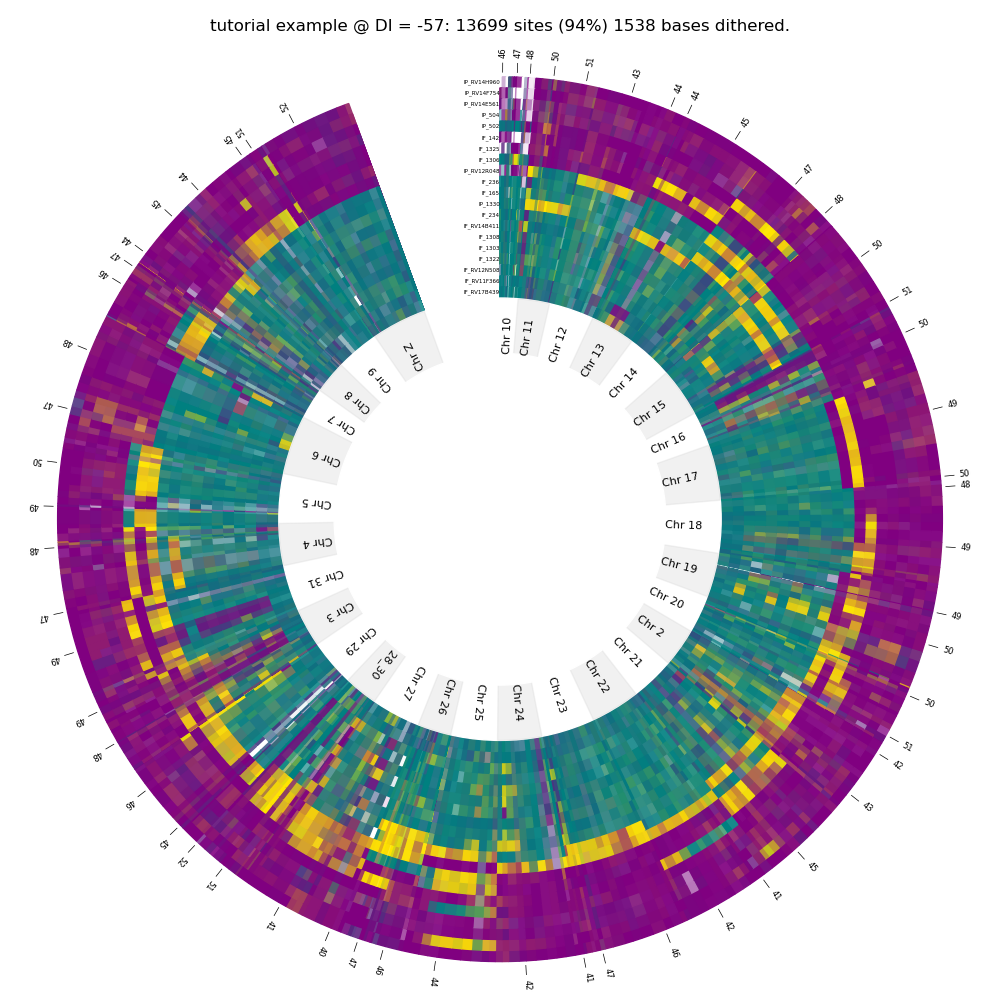

In [61]:
diem.plots.diemIrisFromPlotPrep(MyFirstPlotPrep)

We can straighten out this curl to make a rectangular plot using **diemLongFromPlotPrep**:

You can choose which chromosomes to include.

Again this is browsable.

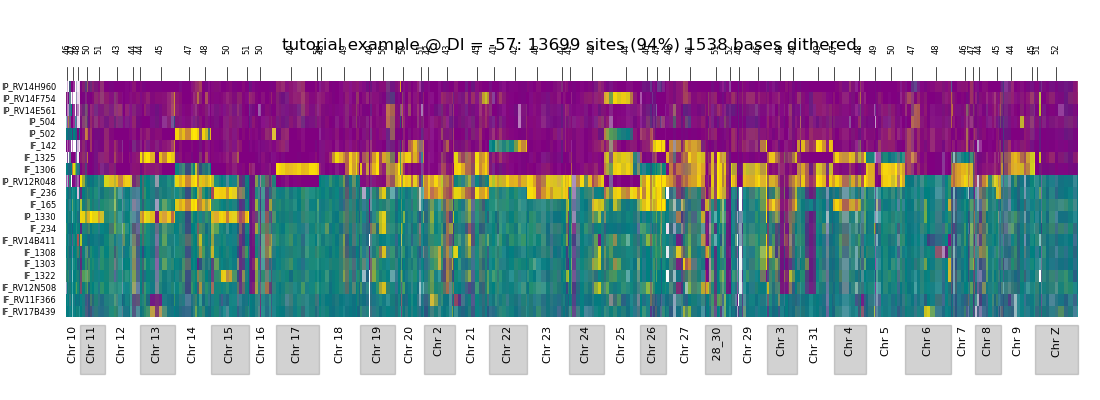

In [62]:
diem.plots.diemLongFromPlotPrep(MyFirstPlotPrep)

You can limit the plot to a subset of chromosomes

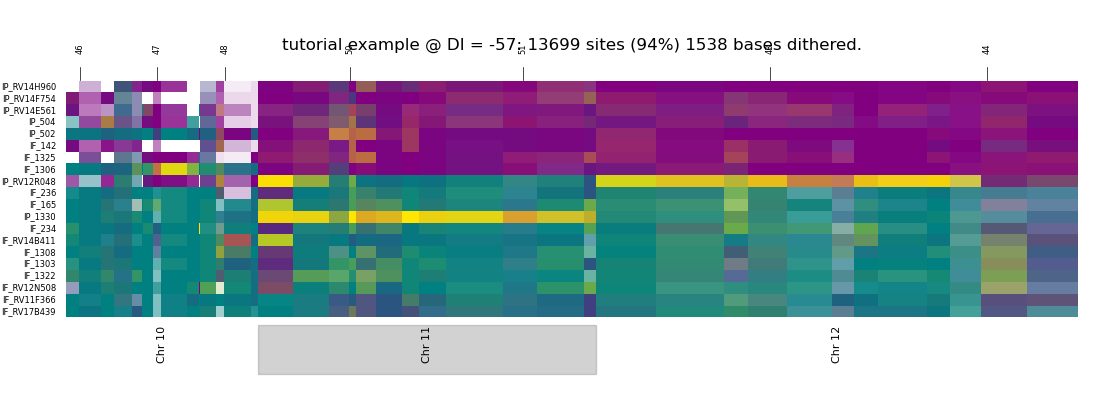

In [63]:
diem.plots.diemLongFromPlotPrep(MyFirstPlotPrep,range(3))

Or you can stack plots of each of your chromosomes:

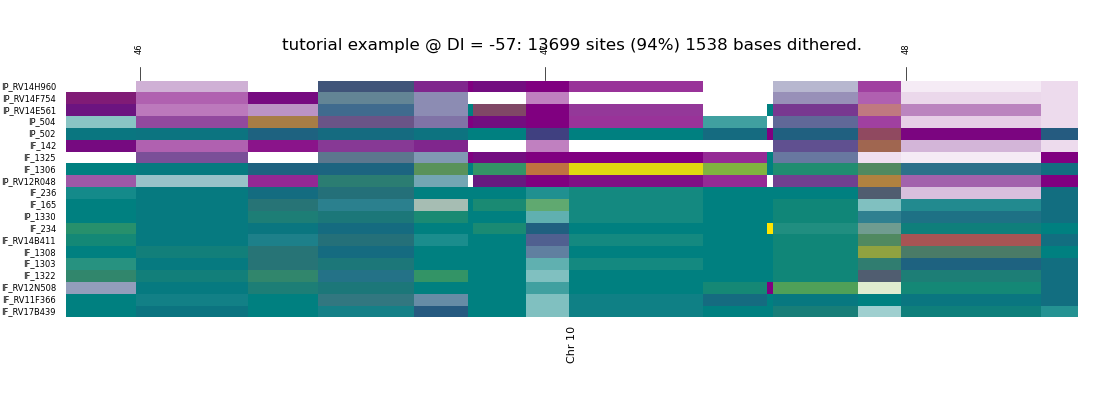

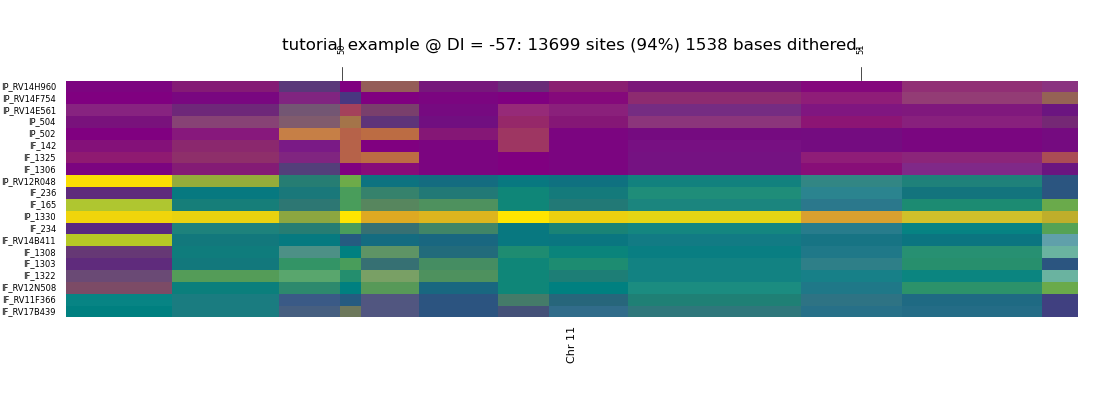

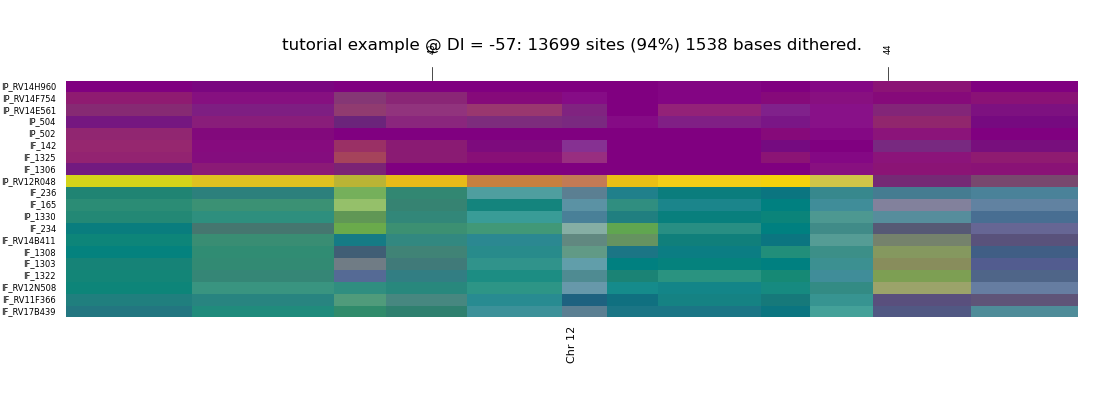

In [64]:
for i in range(3):
    diem.plots.diemLongFromPlotPrep(MyFirstPlotPrep,[i])

# Advanced Polarizing

When running diem, we may want to mask some individual and sites.  Here, masked sites/individuals do not *influence* the barrier (i.e. they don't contribute to the likelihood function). However, they *are* polarized during the EM step along with other sites and individuals. 

We have included two example exclusion files under the user_files subdirectory.

Here, we mask individuals that were sampled outside of france and spain.

We also (arbitrarily) mask chromosome 2 for this example.

Although we have masked both sites and individuals in this example, it possible to specify only one or the other. Any masks have been added to the raw data will be used in polarization. 

In [65]:
# #### add information about individuals that do not influence polarization. We say 'excluded' but really mean 'masked'
sitesMaskedFile = './user_files/sites_masked.bed'
individualsMaskedFile = './user_files/individuals_masked.txt'

dRawWithMasks = dRaw.copy()

dRawWithMasks.add_individual_exclusions(individualsMaskedFile)
dRawWithMasks.add_site_exclusions(sitesMaskedFile)

In [66]:
dRawWithMasks.siteExclusionsByChr[12]

[1, 3, 4, 5, 6]

In [67]:
dPolWithMasks = dRawWithMasks.polarize()
dPolWithMasks.sort()

convert state matrix to Marray
initializing random polarity
running EM algorithm in parallel using diem_parallel with  8  cores
starting
using  8  CPUs
iteration  0   num 0 polarity =  7315   num 1 polarity =  7320
time to flip:  0.251997709274292
iteration  1   num 0 polarity =  9370   num 1 polarity =  5265
time to flip:  0.2301473617553711
iteration  2   num 0 polarity =  11656   num 1 polarity =  2979
time to flip:  0.21400237083435059
iteration  3   num 0 polarity =  12806   num 1 polarity =  1829
time to flip:  0.271559476852417
iteration  4   num 0 polarity =  12602   num 1 polarity =  2033
time to flip:  0.21245265007019043
iteration  5   num 0 polarity =  12670   num 1 polarity =  1965
time to flip:  0.23282861709594727
iteration  6   num 0 polarity =  12671   num 1 polarity =  1964
time to flip:  0.2037055492401123
polarity found
polarity found
updating polarizations, DIs, Supports, initialPolarity,and state matrices
new HIs computer and individuals resorted by HI


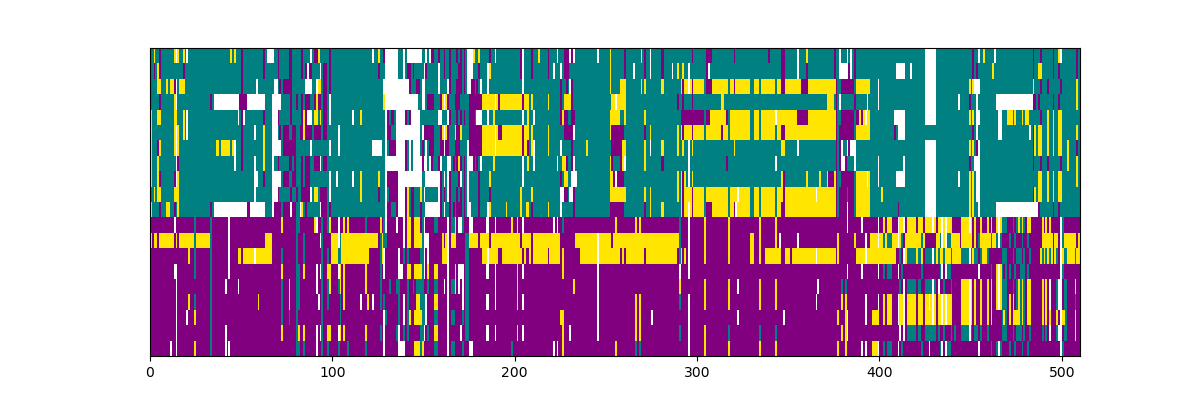

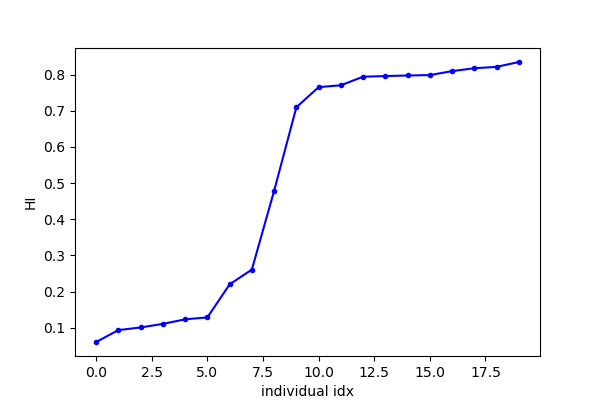

In [68]:
diem.plot_painting(dPolWithMasks.DMBC[9])

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(dPolWithMasks.HIs,marker='.',color='b')
ax.set_ylabel('HI')
ax.set_xlabel('individual idx')
plt.show()

# Advanced Smoothing

By default, DiemPy normalizes all chromosomes to the same map length and uses the same smoothing scale across all chromosomes.

This makes sense for organisms like the Lepidopterans of this example data set, as they experience one recombination event per meiosis.

However, we overlooked a bit of nuance. In Lepidoptera, recombination occurs normally in males, the homogametic sex (ZZ), but is completely absent in females, the heterogametic sex (ZW).

An autosome spends 1/2 of its time in males, so undergoes recombination in 1/2 of its meiotic events.  In contrast, the Z chromsome spends 2/3 of it's time in males, so experiences recombination in 2/3 of its meiotic events.  Therefore, the relative rate of recombination is higher on the Z chromosome compared to an autosome: (2/3) / (1/2) = 4/3.   

We can add this information to the dataset to account for this difference when smoothing. The file 'relative_rec_rates.txt' shows an example of how this is done.  Note that we give a relative rate to each chromsome, however, only chromosomes with a rate that is *not* 1 need to be specified.  

In [71]:
dPolSorted = dPol.copy()
dPolSorted.sort()
dPolSortedWithRecRates = dPolSorted.copy()
dPolSortedWithRecRates.add_relative_recombination_rates('./user_files/relative_rec_rates.txt')

HIs already up to date, and no sorting needed


In [72]:
dPolSortedWithRecRates.relativeRecRateDict

{'chromosome_10': 1.0,
 'chromosome_11': 1.0,
 'chromosome_12': 1.0,
 'chromosome_13': 1.0,
 'chromosome_14': 1.0,
 'chromosome_15': 1.0,
 'chromosome_16': 1.0,
 'chromosome_17': 1.0,
 'chromosome_18': 1.0,
 'chromosome_19': 1.0,
 'chromosome_20': 1.0,
 'chromosome_2': 1.0,
 'chromosome_21': 1.0,
 'chromosome_22': 1.0,
 'chromosome_23': 1.0,
 'chromosome_24': 1.0,
 'chromosome_25': 1.0,
 'chromosome_26': 1.0,
 'chromosome_27': 1.0,
 'chromosome_28_30': 1.0,
 'chromosome_29': 1.0,
 'chromosome_3': 1.0,
 'chromosome_31': 1.0,
 'chromosome_4': 1.0,
 'chromosome_5': 1.0,
 'chromosome_6': 1.0,
 'chromosome_7': 1.0,
 'chromosome_8': 1.0,
 'chromosome_9': 1.0,
 'chromosome_Z': 1.333}

In [73]:
dSmoothedStandard = dPolSorted.smooth(5e-5)

smoothing the data with scale  5e-05
using parallel smoothing
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort


In [74]:
dSmoothedWithRecRates = dPolSortedWithRecRates.smooth(5e-5)

smoothing the data with scale  5e-05
using parallel smoothing
adjusting smoothing scale by relative recombination rates for each chromosome
smoothing done, but not resorting by HI. You may call the sort() method on the resulting data if you wish to resort


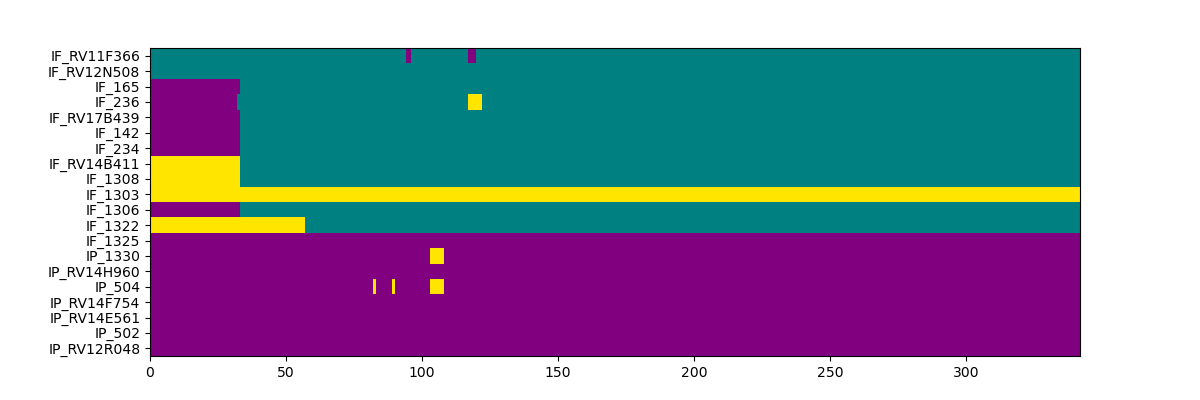

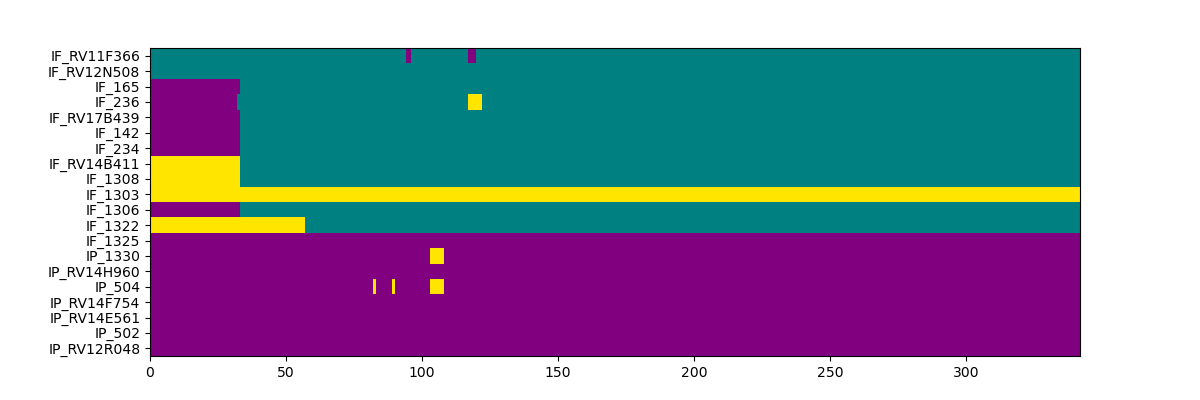

In [75]:
# the smoothing is the same for the autosomes
diem.plot_painting(dSmoothedStandard.DMBC[1],names = dSmoothedStandard.indNames)
diem.plot_painting(dSmoothedWithRecRates.DMBC[1],names = dSmoothedWithRecRates.indNames)

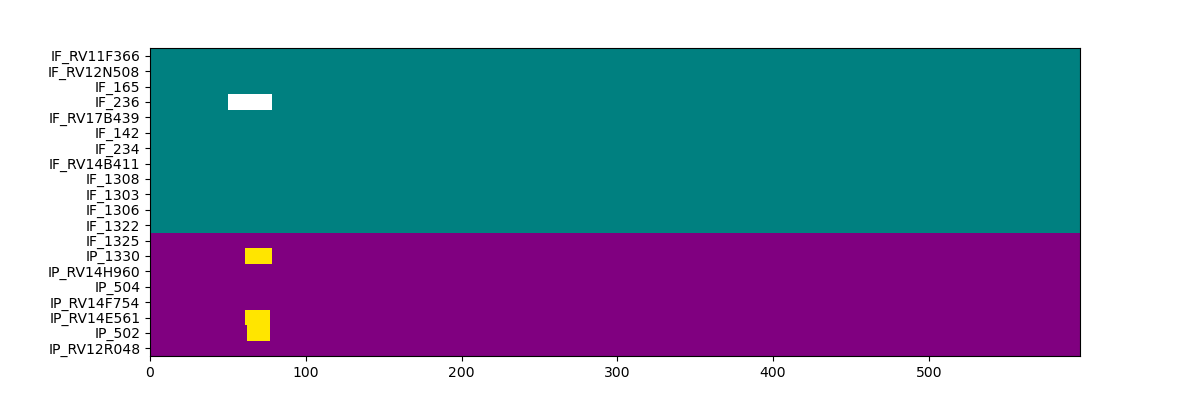

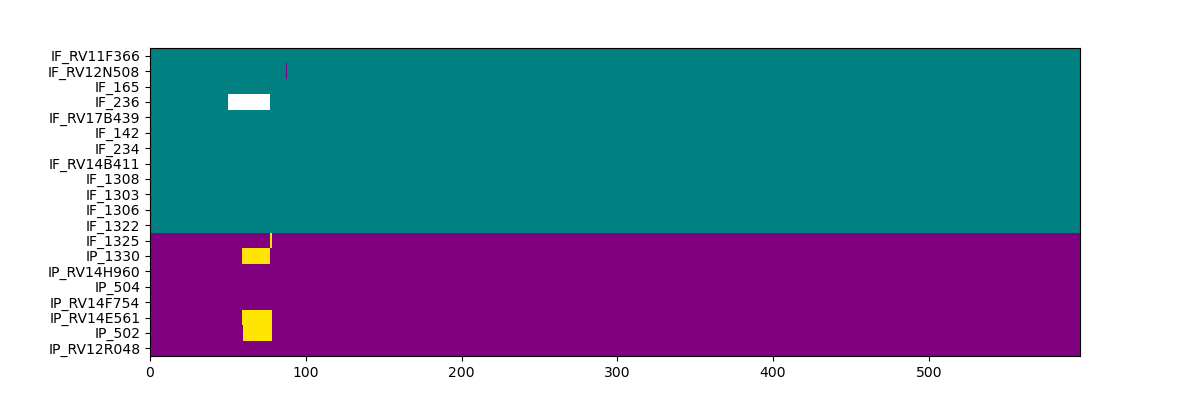

In [76]:
# but the result is different for the sex chromosome:
diem.plot_painting(dSmoothedStandard.DMBC[-1],names = dSmoothedStandard.indNames)
diem.plot_painting(dSmoothedWithRecRates.DMBC[-1],names = dSmoothedWithRecRates.indNames)

** alternative recombination models **

In some organisms, recombination occurs at a per-base-pair rate. In that case, longer chromosomes will have a relatively higher rate of recombination.

To account for this, the user could specify a recombination rate that scales with chromosome size.  For example, if chromosome i has length Li:

chr 1 --> L1 --> L1/L1 = 1.0

chr 2 --> L2 --> L2/L1

chr 3 --> L3 --> L3/L1